# Insect Detection with transfer learning Model

### Objectives
In this notebook we'll:

**Perform** pre-processing and image augmentation on ImageGeneratorClass objects in Keras.
**transfer** learning in the general steps:
obtain pre-trained model,
create base model,
freeze layers,
train new layers on dataset,
improve model through fine tuning.
Build an end-to-end VGG16-based transfer learning model for binary image classification tasks.

### Setup

For this lab, we will be using the following libraries:

* pandas for managing the data.
* numpy for mathematical operations.
* sklearn for machine learning and machine-learning-pipeline related functions.
* seaborn for visualizing the data.
* matplotlib for additional plotting tools.
* keras for loading datasets.

### What is transfer learning?

Most popular models are difficult to train from scratch as they require huge datasets (like ImageNet), a large number of training iterations, and very heavy computing machinery. The basic features (edges, shapes) learned by early layers in a network are generalizable. While the later layers in an already trained network tend to capture features that are more particular to a specific image classification task.

**Transfer learning** uses the idea that if we keep the early layers of a pre-trained network, and re-train the later layers on a specific dataset, we might be able to leverage some state of that network on a related task.

A typical transfer learning workflow in Keras looks something like this:

* Initialize base model, and load pre-trained weights (like ImageNet).
* "Freeze" layers in the base model by setting training = False.
* Define a new model that goes on top of the output of the base model's layers.
* Train resulting model on your data set.

### Python libraries

In [1]:
import numpy as np
import pandas as pd
import os
import random, shutil
import glob
import warnings
warnings.simplefilter('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.image import imread

from os import makedirs,listdir
from shutil import copyfile
from random import seed
from random import random
import keras 
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn import metrics


sns.set_context('notebook')
sns.set_style('white')

2.17.1


Load the images

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf 
from tensorflow import keras
from keras import layers, regularizers

# directory
train_ds = '/kaggle/input/insectv2-dataset/pest/pest/train'
test_ds = '/kaggle/input/insectv2-dataset/pest/pest/test'

# label of images
classes = os.listdir(train_ds)


In [3]:
img_rows, img_cols = 224, 224
batch_size = 64
n_epochs = 50
val_split = 0.2
verbosity = 1
input_shape = (img_rows, img_cols, 3)
seed = 10
#checkpoint_path='ORnet.h5'

beetle: 291 images
mites: 254 images
grasshopper: 277 images
sawfly: 200 images
stem_borer: 181 images
mosquito: 295 images
armyworm: 223 images
aphids: 266 images
bollworm: 245 images
Total images are 2232


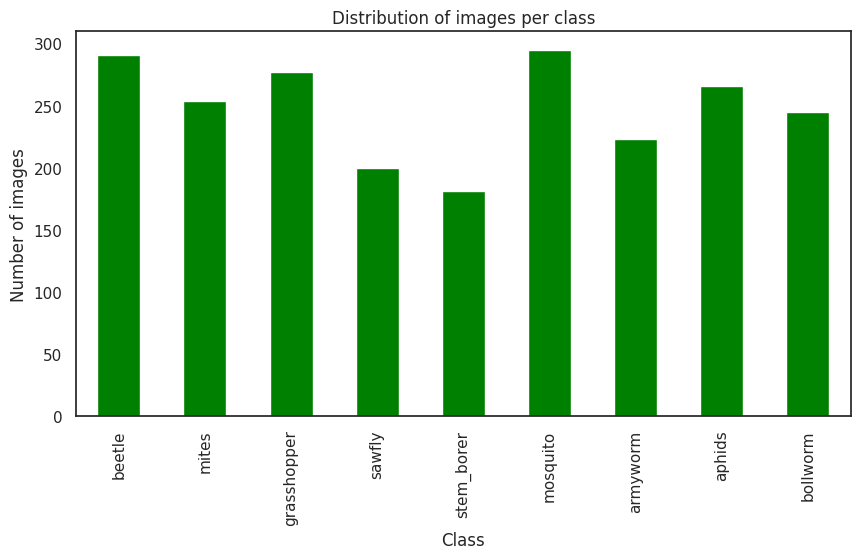

In [4]:
# Count the number of images in each class
image_counts = {cls: len(os.listdir(os.path.join(train_ds, cls))) for cls in classes}
for cls, count in image_counts.items():
    print(f"{cls}: {count} images")
total = sum(image_counts.values())
print(f"Total images are {total}")

from matplotlib import pyplot as plt

# Plotting the distribution of images
plt.figure(figsize=(10, 5))
pd.Series(image_counts).plot(kind='bar', color='g')
plt.title('Distribution of images per class')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.show()


Visualize some images

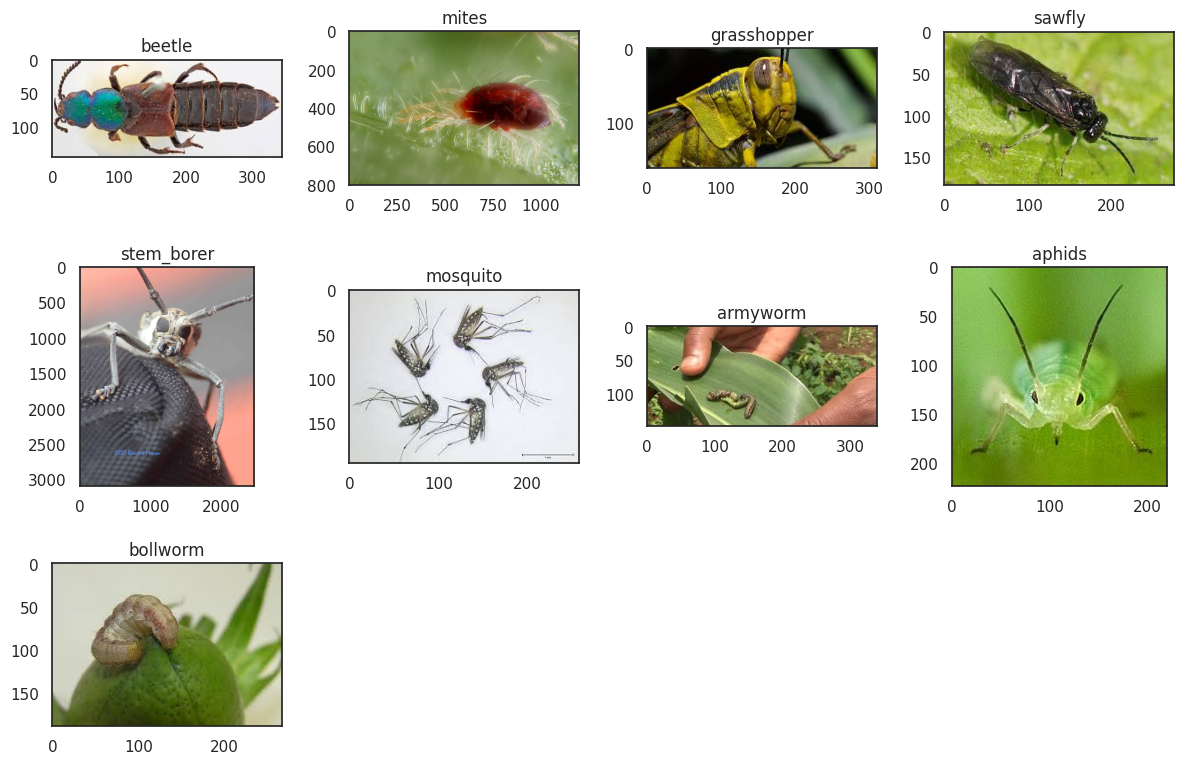

In [5]:
import matplotlib.pyplot as plt
import os
from PIL import Image

plt.figure(figsize=(12,8))
for i, cls in enumerate(classes):
    cls_path = os.path.join(train_ds, cls)
    img_path = os.path.join(cls_path, os.listdir(cls_path)[0])
    img = Image.open(img_path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(cls)

plt.tight_layout()
plt.show()

In [6]:
train_ds

'/kaggle/input/insectv2-dataset/pest/pest/train'

### Image Augmentation
Now we will create ImageDataGenerators used for training, validation, and testing.

Image data generators create batches of tensor image data with real-time data augmentation. They loop over the data in batches and are useful in feeding data to the training process. We specify a 20% validation split.

We will perform a few image augmentation steps. We set rescale to 1./255. This means that each image pixel will be divided by 255 in order to normalize the image. We set the width_shift_range and height_shift_range to 0.1 each, and the horizontal_flip to True.

* The width_shift_range shifts the image horizontally (left or right).
* The height_shift_range shifts the image vertically (up or down).
* The horizontal_flip randomly flip inputs horizontally.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerators for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True
)

Since it is undesirable to load all of our image data into memory all at once, we make use of the flow_from_directory method. It takes the ImageDataGenerator training/validation sets and flows image batches from a specified folder.

* We set directory to the path, specifying the path to our training dataset.
* We specify classes using labels we had defined in the configuration step.
* We apply a seed so our random initializer is generated in the same way each time we perform this step. This allows for direct comparison between experiments.

In [8]:
# find number of images belonging to each category
train_generator = train_datagen.flow_from_directory(
    directory = train_ds,
    batch_size = batch_size, 
    class_mode='categorical',
    shuffle = True,
    target_size=(img_rows, img_rows),
    )

val_generator = test_datagen.flow_from_directory(
    directory = test_ds,
    batch_size = batch_size, 
    class_mode='categorical',
    shuffle = True,
    target_size=(img_rows, img_rows),
    )

test_generator = test_datagen.flow_from_directory(
    directory = test_ds,
    class_mode='categorical',
    batch_size = batch_size, 
    shuffle = True,
    target_size=(img_rows, img_rows)
)

Found 2232 images belonging to 9 classes.
Found 384 images belonging to 9 classes.
Found 384 images belonging to 9 classes.


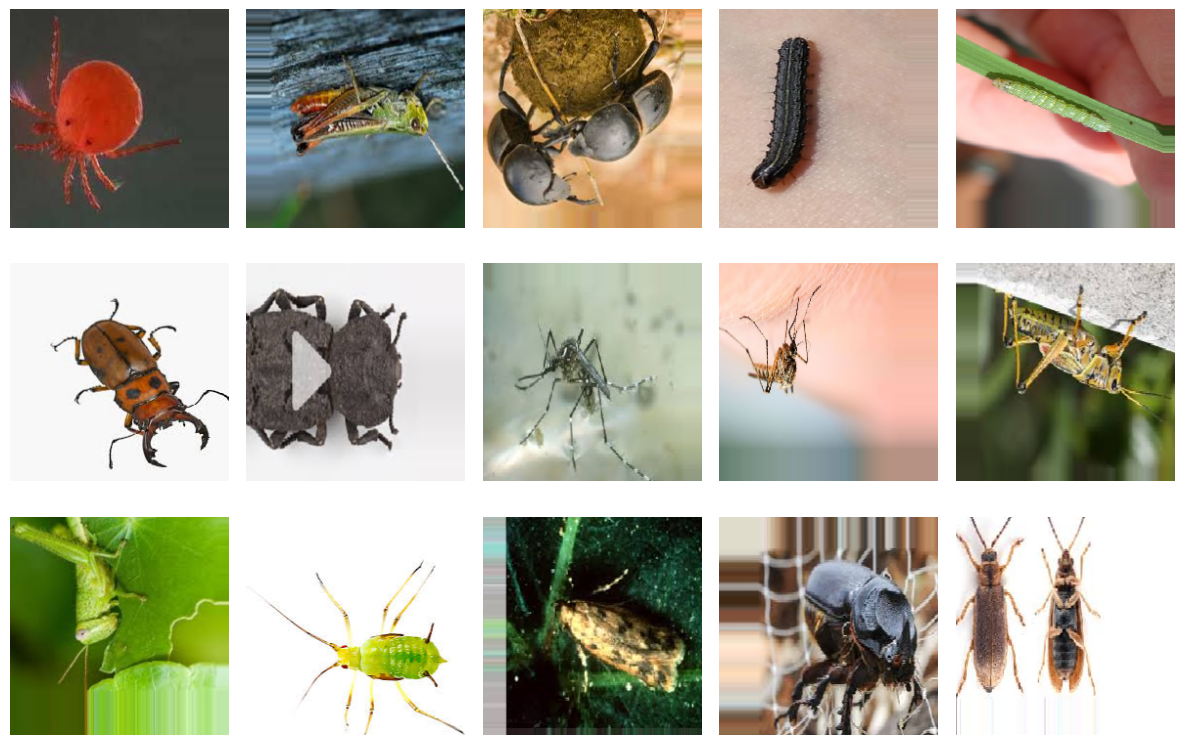

In [9]:
x_batch, labels = next(train_generator)

plt.figure(figsize=(12, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_batch[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## VGG-16

Let us load the VGG16 model.

```python
tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_shape=None,
)
```
The default input image size for this model is 224x224.

Further information on arguments can be found in the Keras [documentation](https://keras.io/api/applications/vgg/).

>Note: Each Keras Application expects a specific kind of input preprocessing. For VGG16, call `tf.keras.applications.vgg16.preprocess_input` on your inputs before passing them to the `model.vgg16.preprocess_input` will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

>* __include_top__: whether to include the fully-connected layer at the top of the network.
>* __weights__: one of None (random initialization), 'imagenet' (pre-trained on ImageNet), or the path to the weights file to be loaded.
>* __input_shape__: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3). 

In [10]:
from keras.applications import vgg16
input_shape = (224, 224, 3)

vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We flatten the output of a vgg model and assign it to the model ```output```, we then use a Model object ```basemodel``` to group the layers into an object for training and inference .
With the following inputs and outputs  

inputs: ```vgg.input```

outputs: ```tf.keras.layers.Flatten()(output)```

In [11]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

#Next, we freeze the basemodel, like the lower layers.
basemodel.trainable = False
for layer in basemodel.layers: layer.trainable = False

In [12]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu', input_dim=(224,224,3)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(9, activation='sigmoid'))

### check the number of parameters

In [13]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional (Functional)              │ (None, 25088)               │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,827,529 (106.15 MB)

 Trainable params: 13,112,841 (50.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


Let us print the model summary

### Compile the model

Calling `compile()` freezes the behavior of that model, implying that the trainable attribute values at the time of compilation are preserved.

We use RMSProp as our optimizer with a learning rate of 2e-5, Binary Cross Entropy Loss as our loss function and Accuracy as our primary metric for model evaluation as we have 2 labels in our dataset.


We use early stopping to avoid over-training the model. An over-trained model overfits the training dataset and has poor performance on unseen test sets. We will also use a exponential step-decay based learning rate scheduler

### Fit and train the model

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.fit(train_generator,
     epochs=n_epochs,
    validation_data=val_generator,
        callbacks=[early_stopping])

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.1768 - loss: 4.3572 - val_accuracy: 0.3828 - val_loss: 1.7236
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 38s 900ms/step - accuracy: 0.3644 - loss: 1.7843 - val_accuracy: 0.5755 - val_loss: 1.4049
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 839ms/step - accuracy: 0.4880 - loss: 1.4970 - val_accuracy: 0.4245 - val_loss: 1.6708
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 830ms/step - accuracy: 0.5506 - loss: 1.3272 - val_accuracy: 0.6745 - val_loss: 0.9912
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 838ms/step - accuracy: 0.6188 - loss: 1.0789 - val_accuracy: 0.7214 - val_loss: 0.8890
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 868ms/step - accuracy: 0.6700 - loss: 1.0100 - val_accuracy: 0.8177 - val_loss: 0.6568
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7133 - loss: 0.8382 - val_accuracy: 0.7891 - val_loss: 0.6392
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 978ms/step - accuracy: 0.7118 - loss: 0.8297 - val_accuracy:

## Evaluation of the model

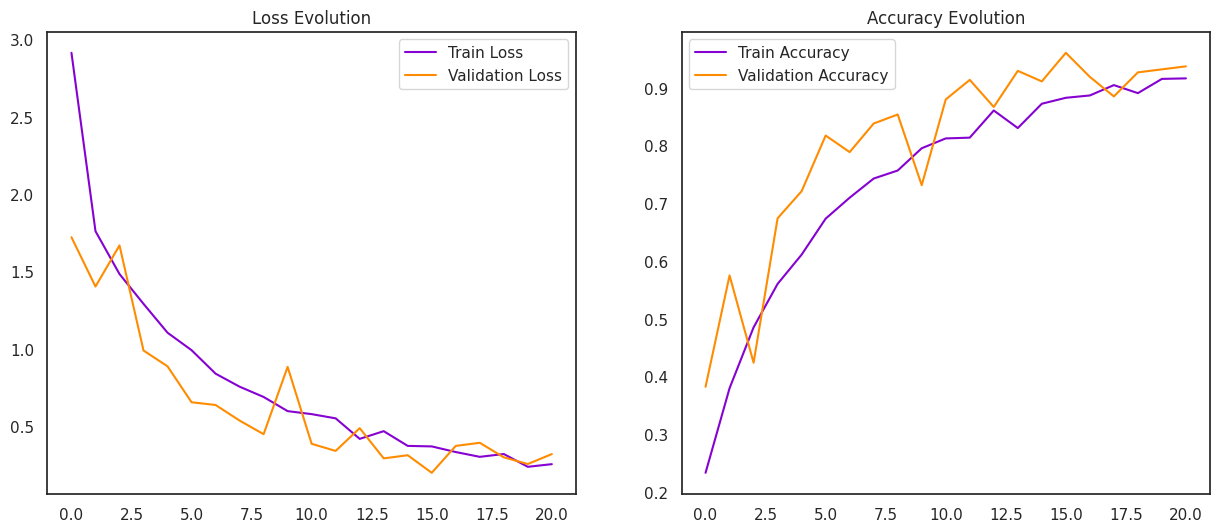

In [15]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [16]:
test_loss, test_accuracy = model.evaluate(
    test_generator,  
    steps=test_generator.samples // batch_size  
)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9671 - loss: 0.2015
Test Loss: 0.2254386991262436
Test Accuracy: 0.9609375


In [17]:
loss, accuracy = model.evaluate(train_generator)
print(f'Train accuracy: {accuracy * 100:.2f}%')

35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 780ms/step - accuracy: 0.9690 - loss: 0.1079
Train accuracy: 97.27%


In [18]:
prob2class = {value: key for key, value in train_generator.class_indices.items()}
prob2class

{0: 'aphids',
 1: 'armyworm',
 2: 'beetle',
 3: 'bollworm',
 4: 'grasshopper',
 5: 'mites',
 6: 'mosquito',
 7: 'sawfly',
 8: 'stem_borer'}

### Defining a helper function for building, compiling, and fitting CNNs

In [19]:
def build_compile_fit(basemodel):
    
    # flatten the output of the base model
    x = Flatten()(basemodel.output)
    # add a fully connected layer 
    x = Dense(1024, activation='relu')(x)
    # add dropout layer for regularization
    x = Dropout(0.2)(x)
    # add final layer for classification
    x = Dense(9, activation='sigmoid')(x)

    model = Model(basemodel.input, x)
      
    early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

    model.fit(train_generator,
     epochs=n_epochs,
    validation_data=val_generator,
        callbacks=[early_stopping])
    
    return model

For our test images, we convert them into numpy arrays with pixel values scaled to 0-1. The test data will not be seen by the model during training or validation, but they will be used to evaluate the predictive power of our model at the end.

### Pre-trained Model 2: Inception-v3

**Inception-v3** is a successor to Inception-v1 with 24 million parameters and ran 48 layers deep. 

Instead of focusing on increasing the depth of the network, InceptionNet focuses on increasing the width and depth of the model simultaneously to attain better accuracy, while keeping the computing resources constant. 

It focuses on **parallel processing** and extraction of various feature maps concurrently using **Inception modules**, which are collections of convolutions with different filter sizes and pooling operations. The following is an illustration of the inception module in inception-v1 architecture:

<center>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L2/img/Inception_v1_module.png"></center>

Picture credits to [Wichai Puarungroj](https://www.researchgate.net/profile/Wichai-Puarungroj-2)

The inception architecture was refined in various ways, specifically for inception-v3, the following improvements are incorporated to achieve less expensive and still efficient networks:

- Factorization Into Smaller Convolutions
- Factorization Into Asymmetric Convolutions
- Auxiliary Classifier used as regularizer
- Efficient Grid Size Reduction

You can read more about the different versions of InceptionNet [here](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202)

In [20]:
from keras.applications.inception_v3 import InceptionV3

# initialize the base model
basemodel = InceptionV3(input_shape=(224,224,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False

# call the build_compile_fit function to complete model training
inception_v3 = build_compile_fit(basemodel)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.2253 - loss: 55.8579 - val_accuracy: 0.5938 - val_loss: 4.4303
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 842ms/step - accuracy: 0.6245 - loss: 2.5851 - val_accuracy: 0.5365 - val_loss: 2.3517
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 867ms/step - accuracy: 0.5928 - loss: 2.0165 - val_accuracy: 0.7318 - val_loss: 1.3724
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 831ms/step - accuracy: 0.7033 - loss: 1.1817 - val_accuracy: 0.6797 - val_loss: 1.3101
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 784ms/step - accuracy: 0.7182 - loss: 1.2219 - val_accuracy: 0.6771 - val_loss: 1.4271
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 786ms/step - accuracy: 0.7395 - loss: 0.9937 - val_accuracy: 0.8984 - val_loss: 0.4146
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 778ms/step - accuracy: 0.8008 - loss: 0.7571 - val_accuracy: 0.8464 - val_loss: 0.5812
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 782ms/

The pre-trained part of our **inception_v3** model utilizes the weights obtained from the imagenet dataset training. Only the layers that we added are trained on the stop sign's data.

Let's now display the test images along with their class labels predicted by the fitted **inception_v3**:

**After traing the models we'd like to test the model predictability**

In [21]:
test_loss, test_accuracy = inception_v3.evaluate(
    test_generator,  
    steps=test_generator.samples // batch_size  
)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 831ms/step - accuracy: 0.9374 - loss: 0.2157
Test Loss: 0.21930229663848877
Test Accuracy: 0.9322916865348816


Let's start with VGG16 MODEL

In [22]:
from tensorflow.keras.preprocessing import image

def predict(train_ds):

    
    label = list(prob2class.values())
    plt.figure(figsize=(12, 19))
    img = Image.open(train_ds)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


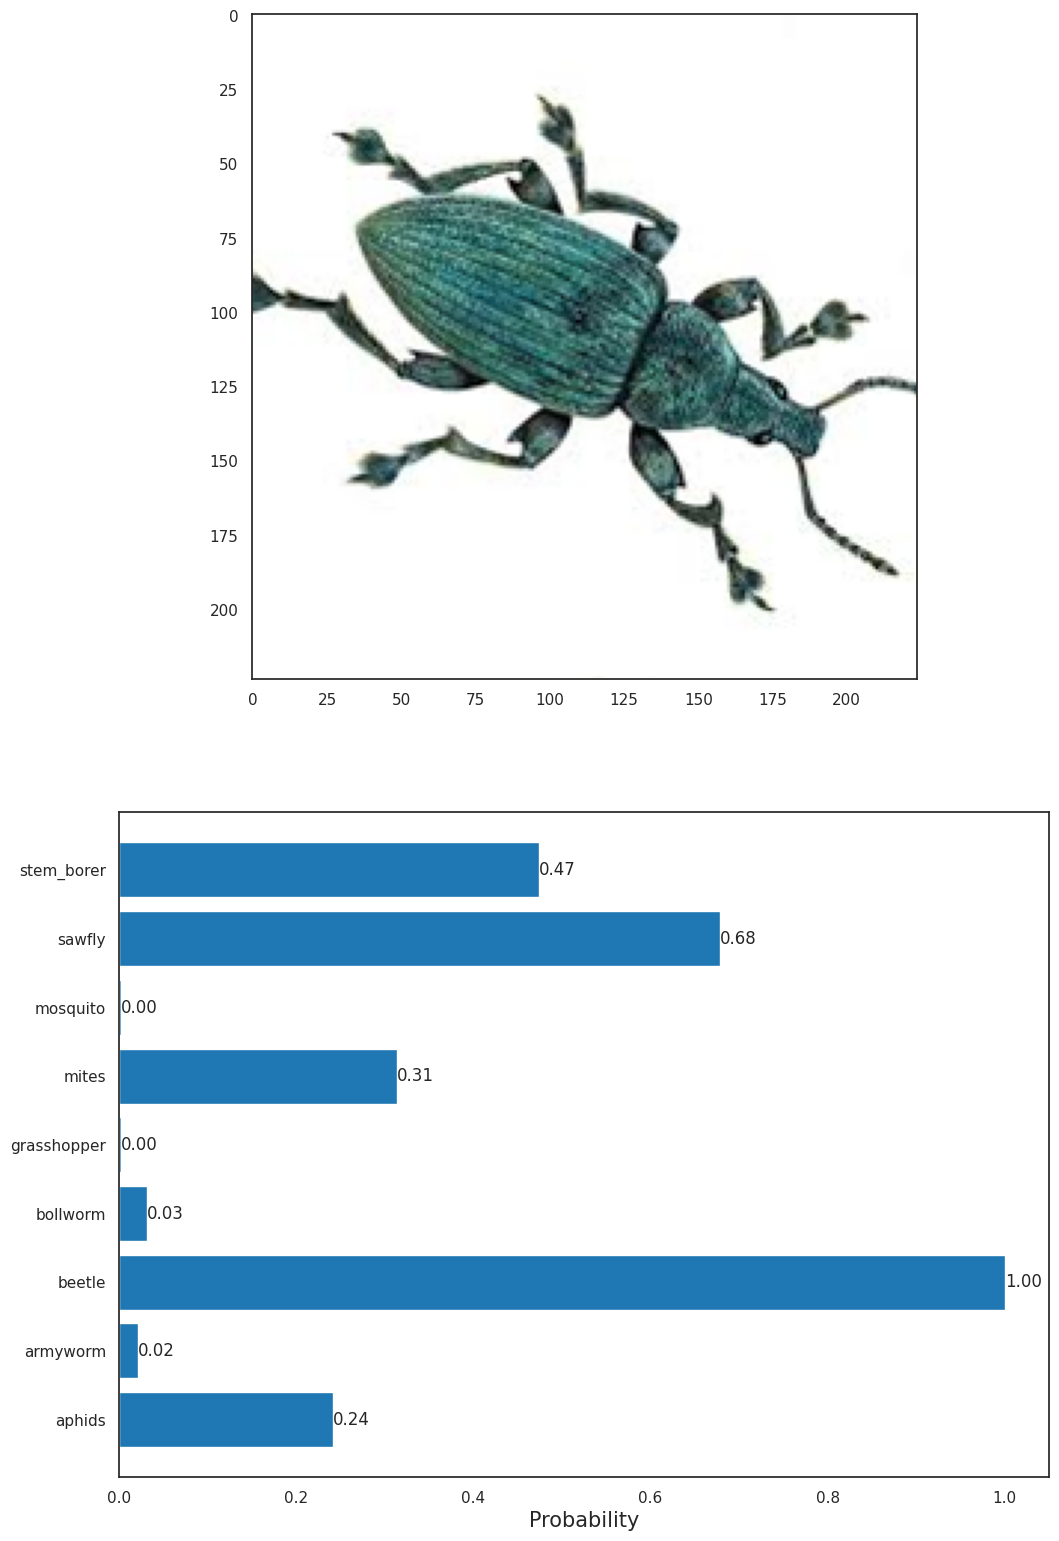

In [23]:
predict(r"/kaggle/input/insectv2-dataset/pest/pest/test/beetle/jpg_9.jpg")

inception_v3 Model prediction test

In [24]:
from tensorflow.keras.preprocessing import image

def predict(train_ds):

    
    label = list(prob2class.values())
    plt.figure(figsize=(12, 19))
    img = Image.open(train_ds)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = inception_v3.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


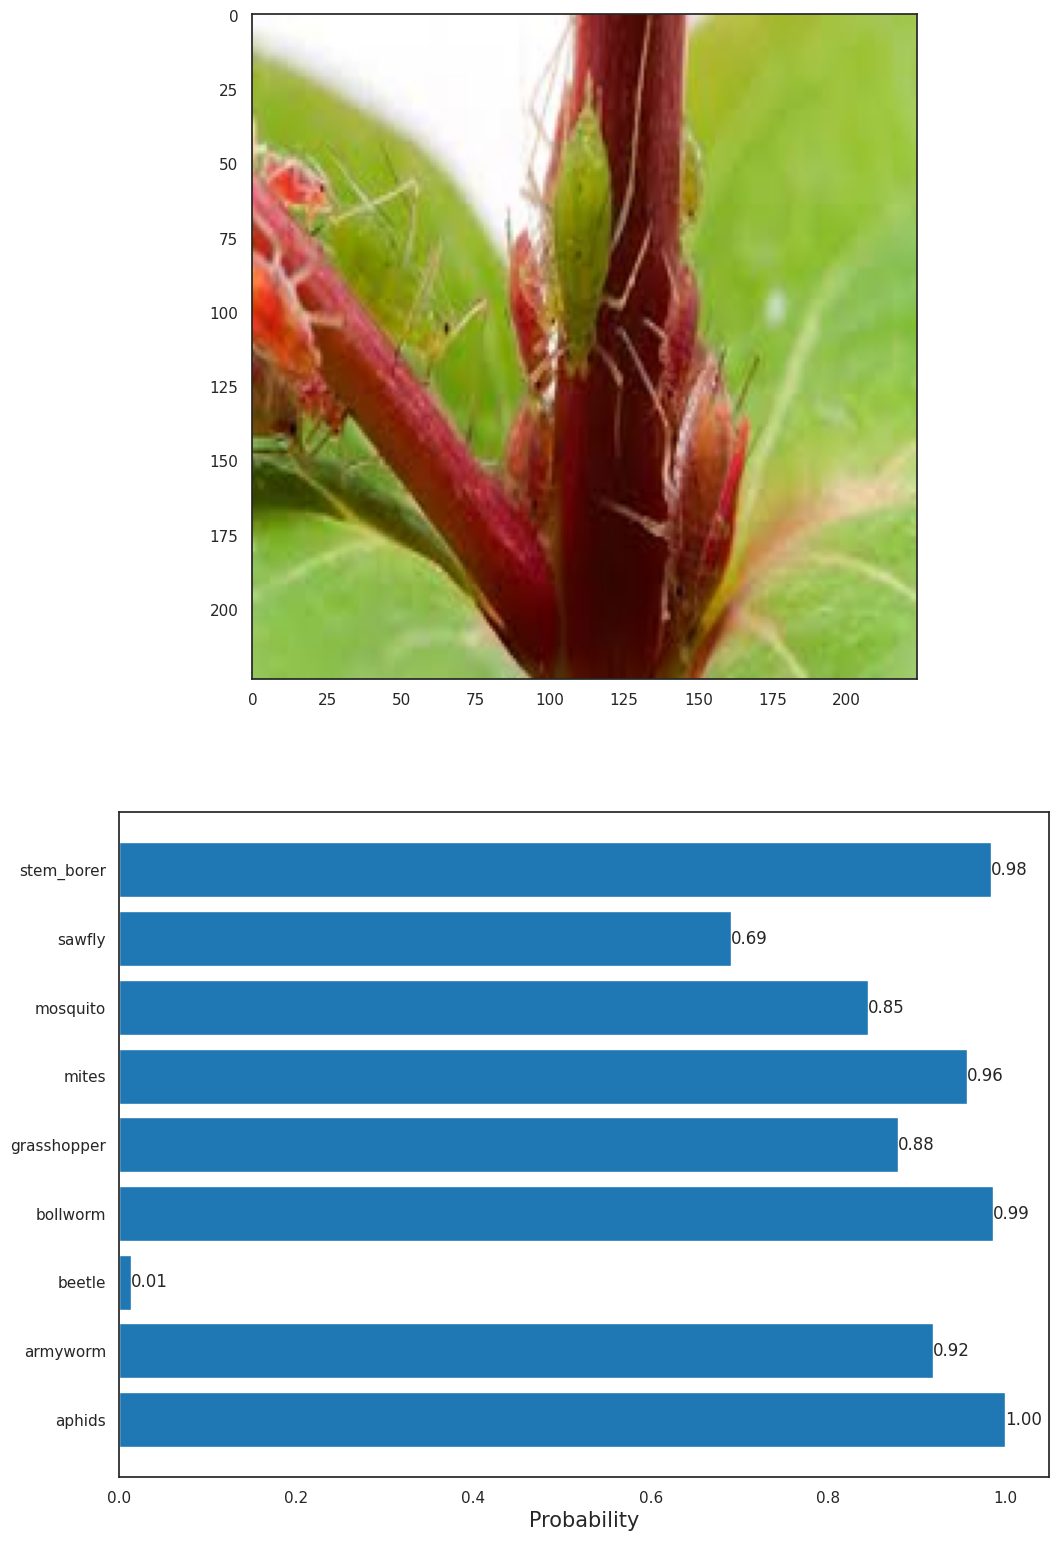

In [25]:
predict(r"/kaggle/input/insectv2-dataset/pest/pest/test/aphids/jpg_23.jpg")

### Pre-trained Model 3: ResNet-50

**ResNet** features special skip connections which add the output from an earlier layer directly to a later layer and heavy use of batch normalization. It allows us to design deep CNNs without compromising the model’s convergence and accuracy. The basic building blocks for ResNets are the convolution and identity blocks. 

Essentially, ResNet uses the network layers to fit a residual mapping $F(x) + x$, instead of trying to learn the desired underlying mapping $H(x)$ directly with stacked layers. 

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L2/img/resnet.png" width="30%"></center>

The formulation of $F(x) + x$ can be realized by the feedforward neural networks with **shortcut connections**. Shortcut connections add the output from the previous layer directly to the output of the current layer, which can be seen as **identity mapping**.

By doing so, the network overcomes the vanishing gradient problem because now the gradient signals could travel back to early layers through this shortcut.


Similarly, let's import the pre-trained ResNet-50 architecture from keras applications.


In [26]:
from keras.applications import ResNet50

# initialize the base model
basemodel = ResNet50(input_shape=(224,224,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False

# call the build_compile_fit function to complete model training
resnet_50 = build_compile_fit(basemodel)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.1178 - loss: 28.0939 - val_accuracy: 0.0990 - val_loss: 4.1719
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 797ms/step - accuracy: 0.1313 - loss: 3.1283 - val_accuracy: 0.1250 - val_loss: 2.2236
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 773ms/step - accuracy: 0.1253 - loss: 2.2412 - val_accuracy: 0.1354 - val_loss: 2.2433
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 803ms/step - accuracy: 0.1364 - loss: 2.2955 - val_accuracy: 0.1276 - val_loss: 2.1733
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 784ms/step - accuracy: 0.1205 - loss: 2.2007 - val_accuracy: 0.1354 - val_loss: 2.1759
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 781ms/step - accuracy: 0.1342 - loss: 2.1998 - val_accuracy: 0.1510 - val_loss: 2.2728
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 809ms/step - accuracy: 0.1529 - loss: 2.2069 - val_accuracy: 0.1458 - val_loss: 2.1441
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 793ms/

In [27]:
test_loss, test_accuracy = resnet_50.evaluate(
    test_generator,  
    steps=test_generator.samples // batch_size  
)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 753ms/step - accuracy: 0.2839 - loss: 1.9233
Test Loss: 1.925971508026123
Test Accuracy: 0.2838541567325592


Let's display the test images along with their class labels predicted by **resnet_50**:

In [28]:
from tensorflow.keras.preprocessing import image

def predict(train_ds):

    
    label = list(prob2class.values())
    plt.figure(figsize=(12, 19))
    img = Image.open(train_ds)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = resnet_50.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

resnet_50 Model prediction test

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


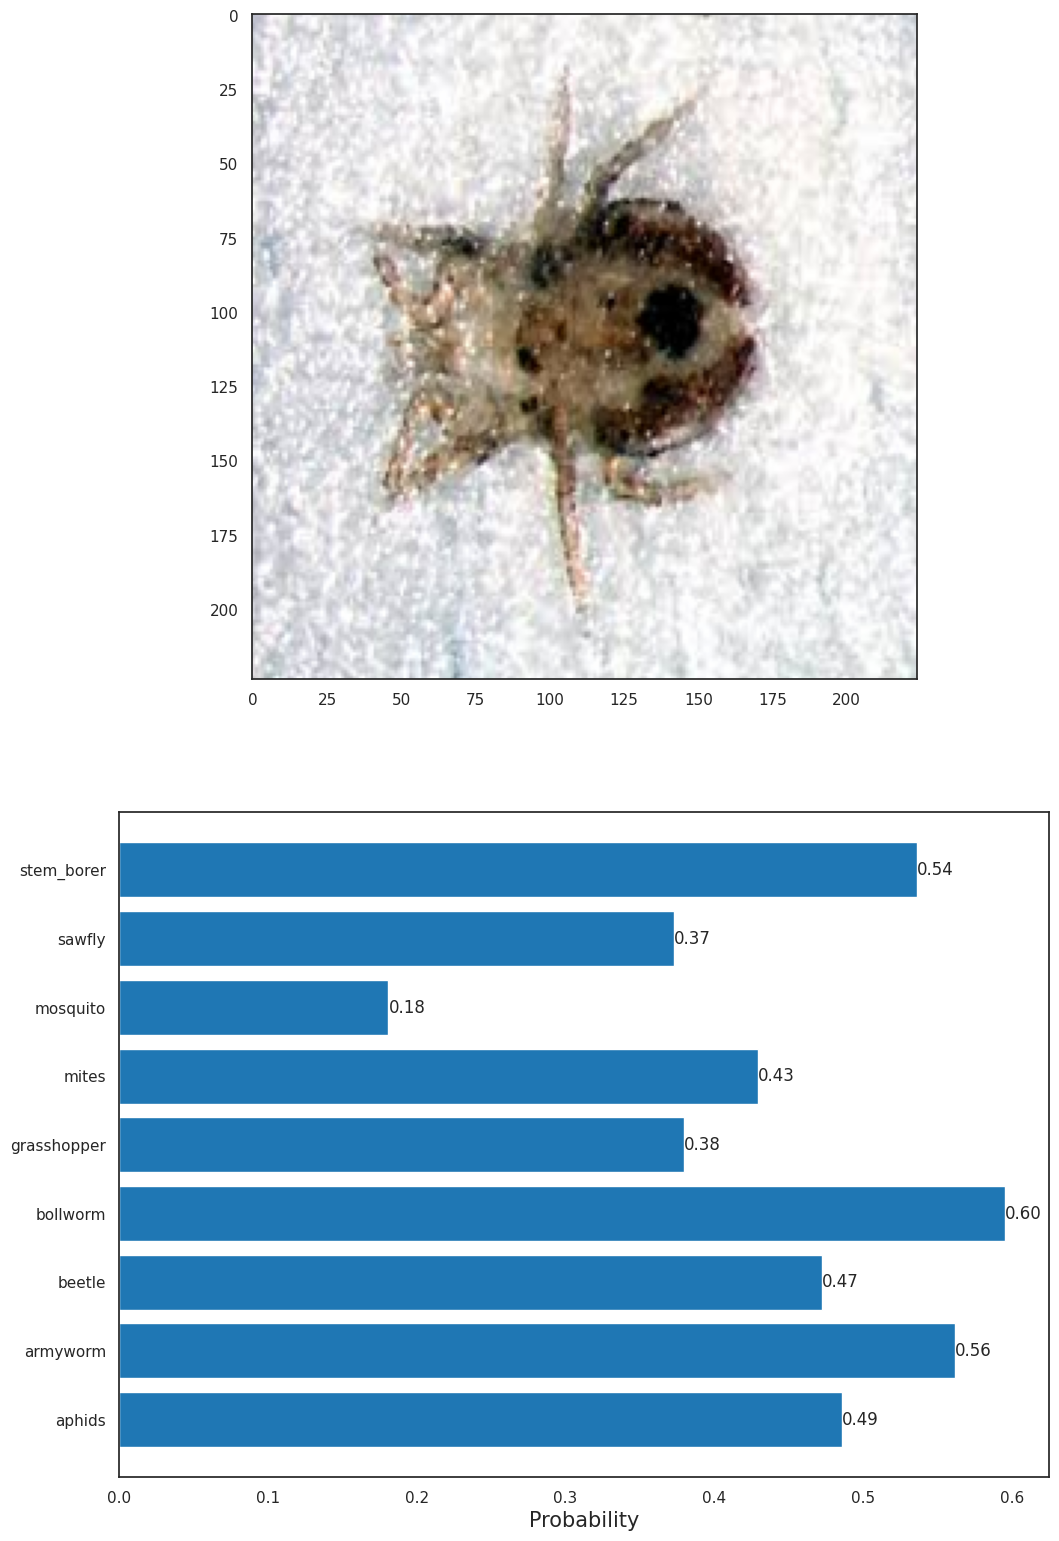

In [29]:
predict(r"/kaggle/input/insectv2-dataset/pest/pest/test/mites/jpg_23.jpg")

In this notebook, we utilized transfer learning techniques to develop and evaluate three popular deep learning models: VGG16, Inception_v3, and ResNet50.

Transfer learning allows us to leverage pre-trained models, saving both time and computational resources while improving model performance on our specific task.

Each of these models was trained successfully, demonstrating their capability to learn from the provided dataset. Once trained, we assessed the predictive performance of all three models to determine their accuracy and loss metrics.

Among the three, VGG16 emerged as the top-performing model, achieving an impressive 94% accuracy with a minimal loss of 0.232 on test data. It was followed closely by Inception_v3, which also performed well but did not surpass VGG16 on the loss test data 0.462. Finally, ResNet50 ranked third, delivering reasonable results but falling short of the performance seen in the other two models.

This project showcases the power and efficiency of transfer learning models in handling complex tasks, while also highlighting the individual strengths and weaknesses of VGG16, Inception_v3, and ResNet50.

Thank you for taking the time to explore this project! 

If you found this work insightful or helpful, please consider upvoting the notebook.